In [1]:
import sys
import warnings

sys.path.append('..')

In [2]:
# import statements, configuration and helper methods
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from statsmodels.graphics.gofplots import qqplot # source: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
from scipy.stats import linregress
from scripts import project_functions as pf



# set theme
sns.set_theme(style="darkgrid")
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True}) # set minor tick
figure_size=[10, 5]

# # fontsizes
# font = {'family' : 'monospace',
#           'weight' : 'bold',
#           'size'   : 34}
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 20

# plt.rc('font', **font)
# plt.rc('fontsize', )
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.titlesize'] = BIGGER_SIZE



# helper methods
def annotate(x, y):
    """annotate text: <location> at the given data_points"""
    ax.annotate('  ({:.2f}, {:.2f})'.format(x, y), xy=(x, y))

# Exploratory Data Analysis(EDA) on the Happiness Index 2021
In this notebook we will visualize and explain the reasoning behind the ladder score that was shown on the Happiness Report 2021. Further in, we will attempt to generate a simple linear regression model and create a prediction interval function for our model. We will discuss and outline the steps that were taken before we can visualize and interpret the data.

## Data Cleaning Process
Fortunately the datasets provided by the World Happiness Report organization contain no missing value and is sorted according to the ladder score. We could check for missing data with the following.

In [3]:
# read data from csv to df
data_2021 = pd.read_csv('../../data/raw/world-happiness-report-2021.csv')
data_2020 = pd.read_csv('../../data/raw/world-happiness-report-2020.csv')

# check for missing value
print(f'null_summary_2021: \n{data_2021.isnull().sum()}')
print(f'null_summary_2020: \n{data_2020.isnull().sum()}')
# no null values for both datasets so proceed to next step

null_summary_2021: 
Country name                                  0
Regional indicator                            0
Ladder score                                  0
Standard error of ladder score                0
upperwhisker                                  0
lowerwhisker                                  0
Logged GDP per capita                         0
Social support                                0
Healthy life expectancy                       0
Freedom to make life choices                  0
Generosity                                    0
Perceptions of corruption                     0
Ladder score in Dystopia                      0
Explained by: Log GDP per capita              0
Explained by: Social support                  0
Explained by: Healthy life expectancy         0
Explained by: Freedom to make life choices    0
Explained by: Generosity                      0
Explained by: Perceptions of corruption       0
Dystopia + residual                           0
dtype: int64
null_su

## Data Wrangling
In this step we will set up our dataFrame for the visualizing we will do later on. Luckily, we have condensed our data wrangling process into a ready-to-use function. The function can be found under /analysis/scripts/project_functions.py.

In [5]:
df = pf.load_and_process_karel(path_2021='../../data/raw/world-happiness-report-2021.csv', path_2020='../../data/raw/world-happiness-report-2020.csv')
df.head()

,Country name,Regional indicator,Ladder score 2021,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,...,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder score 2020,Score difference
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,...,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253,7.8087,0.0333
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,...,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868,7.6456,-0.0256
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,...,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839,7.5599,0.0111
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,...,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967,7.5045,0.0495
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,...,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798,7.4880,-0.0240


# Exploratory Data Analysis - Introduction
To get a grasp of what our data is. Let us first plot the boxplot of the Happiness Score across the region. Note that, Dystopia is an imaginary country described by the World Happiness Report as "a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors."
<br>
<br>
From the following graph, we can see the distribution of the of happiness across different regions. The ladder score is determined by six features. Next we will plot a correlation map between those features and the ladder score.

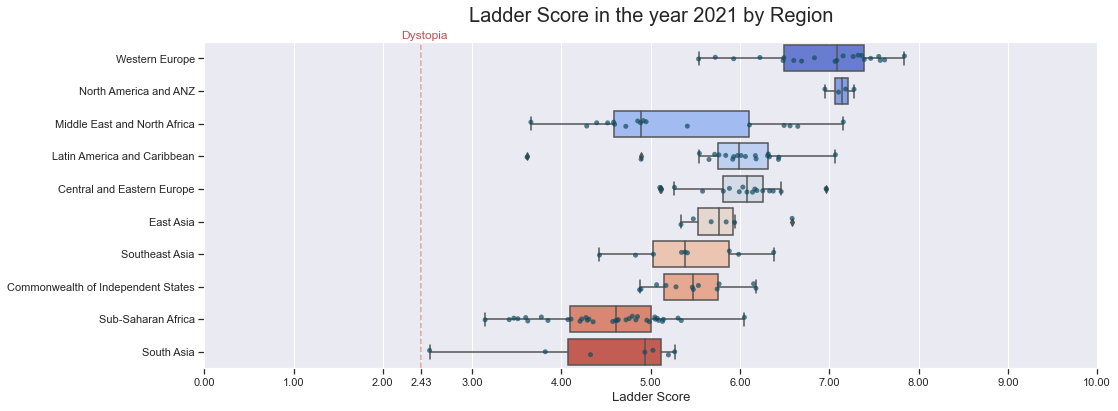

In [6]:
# plotting boxplot per region
fig, ax = plt.subplots(figsize=(16,6))

score_dystopia = df['Ladder score in Dystopia'][0]

ax = sns.boxplot(y='Regional indicator', x='Ladder score 2021', data=df, palette='coolwarm', ax=ax)
ax = sns.stripplot(y='Regional indicator', x='Ladder score 2021', data=df, color='#114b5f', size=5, alpha=.7, ax=ax)
plt.axvline(score_dystopia, color='r', ls='--', alpha=.5)

ax.text(2.2, -0.6, 'Dystopia', color='r')
# high_ladder = df.iloc[df['Ladder score 2021'].idxmax()]['Country name']
# low_ladder = df.iloc[df['Ladder score 2021'].idxmin()]['Country name']
# print(low_ladder)

ax.set_title(label='Ladder Score in the year 2021 by Region', pad=20)
ax.set(xlabel='Ladder Score', ylabel='')
ax.set_xticks(pd.Series([0., 1., 2., score_dystopia, 3., 4., 5., 6., 7., 8., 9., 10.]))

plt.show()

<br>

# Observing Correlation Between Features
To visualize the correlation we first have to calculate the Pearson's r coefficient for each pair of features, then plot a heatmap for the values.
<br><br>
The graph below shows the linear correlation between the features. From this, it is evident that the happiness score of a country is positively correlated greatly with the logged GDP per capita.

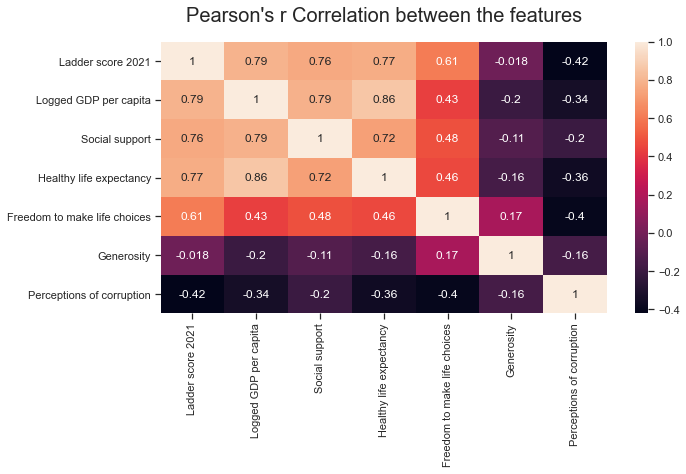

In [21]:
# pick columns to be heatmapped
cols = ['Ladder score 2021', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

df_corr = df[cols].corr() # creating dataFrame containing Pearson's r values to plot heatmap

# plotting heatmap for the features(columns)
fig, ax = plt.subplots(figsize=figure_size)

ax = sns.heatmap(data=df_corr, yticklabels=df_corr.columns, xticklabels=df_corr.columns, annot=True)

ax.set_title(label='Pearson\'s r Correlation between the features', pad=20)
plt.show()

## Scatterplot Ladder Score to Logged GDP per Capita
Since we have seen that ladder score have the strongest correlation coefficienf of 0.79 with logged GDP per capita, let us plot the datas to visualize their relationship.

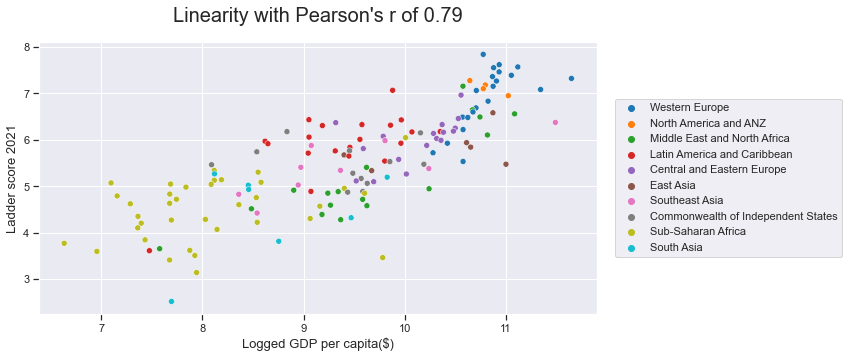

In [8]:
fig, ax = plt.subplots(figsize=figure_size)

x_axis = 'Logged GDP per capita'
y_axis = 'Ladder score 2021'

ax = sns.scatterplot(y=y_axis, x=x_axis, data=df, hue='Regional indicator', palette='tab10')
# ax = sns.regplot(y=y_axis, x=x_axis, data=df, color='navy', scatter=False)

ax.set_title(label='Linearity with Pearson\'s r of 0.79', pad=20)
ax.legend(loc='right', bbox_to_anchor=(1.45, 0.5))
ax.set(xlabel='Logged GDP per capita($)')

plt.show()

To make things more interesting we can attempt to make this line a model for a ladder score for a given Logged GDP per capita. For that though, we have to check the following factors:
- normality, qqplot
- linearity, scatterplot
- constant variance, residual-fitted plot
- independence
<br><br>

From the scatterplot and Pearson's r coefficient, it is reasonable to expect a linear relationship between the features. Next, we will plot resid-fitted plot to check for constant variance.

## Residual Plot
The random scattering around the zero shows that there is a constant variance. Next we will draw a qqplot to show normality of the data.

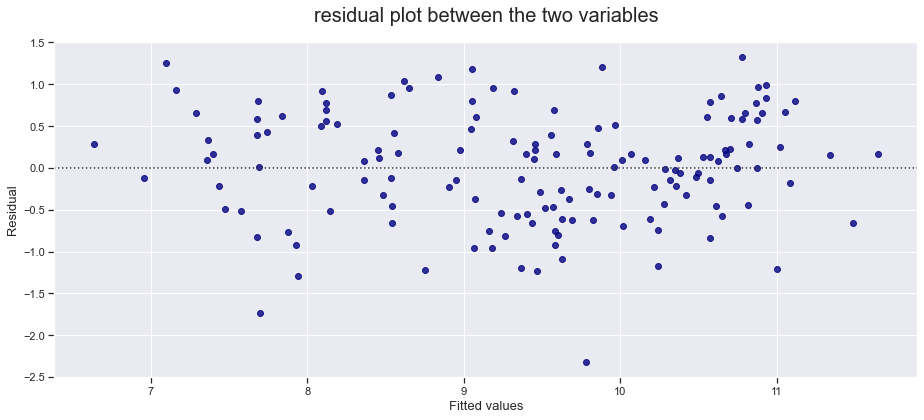

In [17]:
fig, ax = plt.subplots(figsize=(13, 6))

ax = sns.residplot(y='Ladder score 2021', x='Logged GDP per capita', data=df, color='navy')

ax.set_title(label='residual plot between the two variables', pad=20)
ax.set(ylabel='Residual', xlabel='Fitted values')
fig.tight_layout()
plt.show()

## QQplot
Both features has a scattering around the standard line, which proves normality.

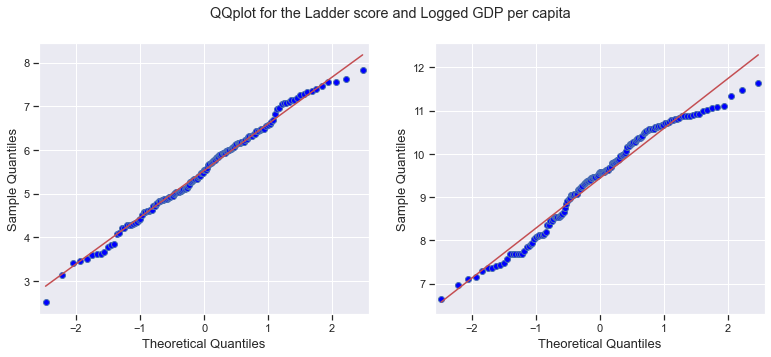

In [10]:
# check for normality by qqplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))
with warnings.catch_warnings(): # to supress warning
    warnings.simplefilter("ignore")
    
    qqplot(df['Ladder score 2021'], line='s', ax=ax1)
    qqplot(df['Logged GDP per capita'], line='s', ax=ax2)

fig.suptitle(t='QQplot for the Ladder score and Logged GDP per capita')
plt.show()

Now that we know the data on the two axis is normal, has constant variance, and random scattering on the residual-fitted plot, we can confidently say that the linear regression model above is proven to be reasonable.

# Linear Regression Model for Ladder Score vs Logged GDP per Capita
First thing first, we will utilize a function from seaborn to plot our regression model. The shaded region is a 95% confidence interval for the true trend line for the data.

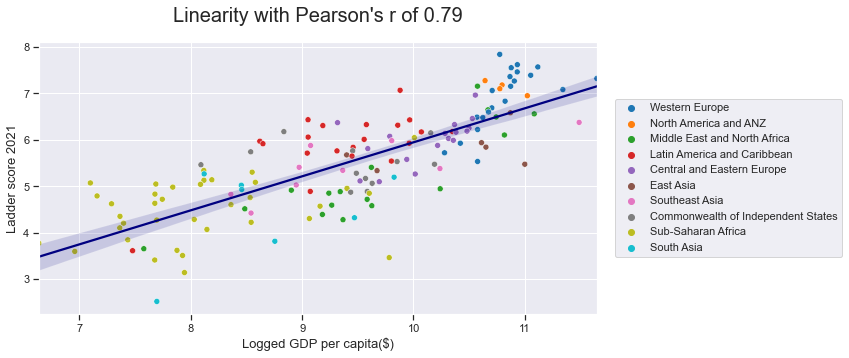

In [11]:
fig, ax = plt.subplots(figsize=figure_size)

x_axis = 'Logged GDP per capita'
y_axis = 'Ladder score 2021'

ax = sns.scatterplot(y=y_axis, x=x_axis, data=df, hue='Regional indicator', palette='tab10')
ax = sns.regplot(y=y_axis, x=x_axis, data=df, color='navy', scatter=False)

ax.set_title(label='Linearity with Pearson\'s r of 0.79', pad=20)
ax.legend(loc='right', bbox_to_anchor=(1.45, 0.5))
ax.set(xlabel='Logged GDP per capita($)')

plt.show()

And now, let us go to the fun and final part of this analysis.

## Prediction Interval
For this final part, we will be using this [blog](https://machinelearningmastery.com/prediction-intervals-for-machine-learning/) written by Dr Jason Brownlee as a guidance. Although Dr Brownlee did a great job of explaining how we can plot the PI, for this analysis, the calculation of PI is attributed to Dr Irene Vrbik's Lecture notes(see references at the bottom of the page).<br>
<img src="../../images/PI_formula.png" alt="PI_formula" width="600"/>

let's first generate our parameter b1 and b0, then plot our prediction function onto the graph we just drew earlier.

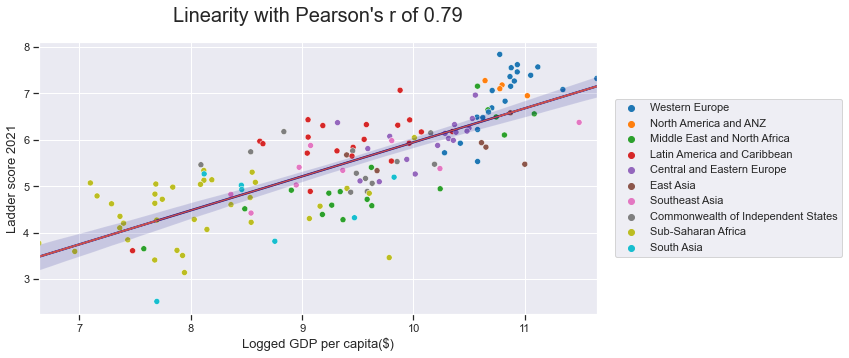

In [12]:
x = df['Logged GDP per capita']
y = df['Ladder score 2021']

b1, b0, r_value, p_value, std_err = linregress(x, y)

# regression model
yhat = b0 + b1*x 

# plotting
fig, ax = plt.subplots(figsize=figure_size)

sns.scatterplot(y=y_axis, x=x_axis, data=df, hue='Regional indicator', palette='tab10', ax=ax)
sns.regplot(y=y_axis, x=x_axis, data=df, color='navy', scatter=False, ax=ax)

ax.plot(x, yhat, color='r')  # our function

ax.set_title(label='Linearity with Pearson\'s r of 0.79', pad=20)
ax.legend(loc='right', bbox_to_anchor=(1.45, 0.5))
ax.set(xlabel='Logged GDP per capita($)')

plt.show()

## Plotting Error Bar
With the line we have above, the next step is to calculate the **standard error** for our model; then we can plot error bar for one of our predicted value. $s^2 formula:$ 
<img src="../../images/sample_variance_formula.png" alt="s_variance_formula" width="600"/>

In [13]:
N = len(y)
sum_square_resd = np.sum((y - yhat)**2)
sample_stddev = (1/(N-2) * sum_square_resd)  # estimate of our population standard deviation

#### Assumption with large number of sample size
Because our population size is `N = len(y) = 149` and $\alpha$=0.05, `t-crit = z-crit = 1.96` is used for the interval.

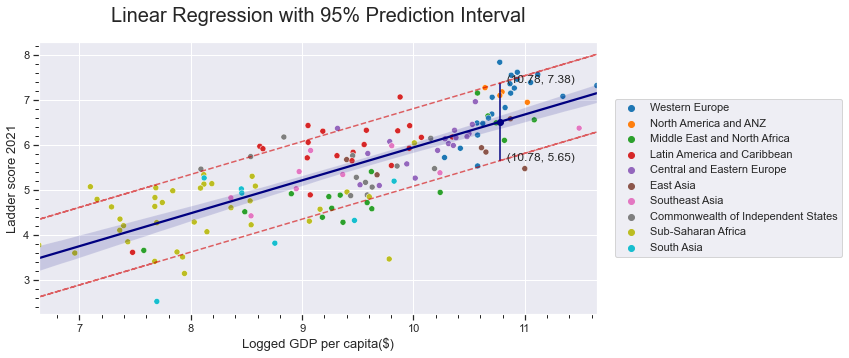

In [14]:
# let x be the first element in list x. yhat be the the prediction for the x_in
x_in = x[0]
y_out = y[0] # true value
yhat_out = yhat[0] # prediction value


Z_CRIT = 1.96  # 95% pred interval
interval_constant = Z_CRIT * sample_stddev * np.sqrt(1 + 1/N + (x_in - np.mean(x))**2 / np.sum( (x - np.mean(x))**2 ))

lower_pred, upper_pred = yhat_out - interval_constant, yhat_out + interval_constant # generate single prediction
lower_arr, upper_arr = yhat - interval_constant, yhat + interval_constant # generate array

fig, ax = plt.subplots(figsize=figure_size)

sns.scatterplot(y=y_axis, x=x_axis, data=df, hue='Regional indicator', palette='tab10', ax=ax)
sns.regplot(y=y_axis, x=x_axis, data=df, color='navy', scatter=False, ax=ax)

# plotting upper and lower interval
ax.plot(x, upper_arr, linestyle='--', color='#D30000', alpha=.6)
ax.plot(x, lower_arr, linestyle='--', color='#D30000', alpha=.6)

# error bar for a single value of x_in
### todo: make funct drawErrorbar()
ax.errorbar(x_in, yhat_out, yerr=interval_constant, color='navy', fmt='o')
annotate(float(x_in), float(lower_pred)) # helper method to annotate at the given datapoints
annotate(float(x_in), float(upper_pred))

ax.set_title(label='Linear Regression with 95% Prediction Interval', pad=20)
ax.legend(loc='right', bbox_to_anchor=(1.45, 0.5))
ax.set(xlabel='Logged GDP per capita($)')
ax.minorticks_on()
# ax.yaxis.set_tick_params(which='minor', left = False) # to turn off minor tick on y-axis

plt.show()

## PI Function
Lastly, to make things more dynamic, let us quickly finalize and wrap everything we just did to a function so that we can visualize a prediction interval for any given value of x.

In [15]:
def PI(logged_gdp_per_capita):
    """
    Plot Prediction Interval for the linear regression model of Ladder score 2021 vs Logged GDP per capita

    Parameters
    ----------
    6.6 <= logged_gdp_per_capita <= 11.6 : float
      The explanatory value: Logged GDP per capita of a country at year 2021 in US dollars.

    Returns
    -------
    void
      instead will plot a visualization of the prediction interval. 
    """
    # input check
    if not(6.6 <= logged_gdp_per_capita <= 11.6):
        print("due to limitation input must be between 6.6 and 11.6. see footnote for more detail.")
        return
    
    # generate linear regression model
    x = df['Logged GDP per capita']
    y = df['Ladder score 2021']

    b1, b0, r_value, p_value, std_err = linregress(x, y)

    yhat = b0 + b1*x  # prediction function

    N = len(y)
    sum_square_resd = np.sum((y - yhat)**2)
    sample_stddev = (1/(N-2) * sum_square_resd)  # estimate of our population standard deviation
    
    # let x be the first element in list x. yhat be the the prediction for the x_in
#     x_in = np.log10(gdp_per_capita)
    x_in = logged_gdp_per_capita
    yhat_out = b0 + b1 * x_in # prediction value


    Z_CRIT = 1.96  # 95% pred interval
    interval_constant = Z_CRIT * sample_stddev * np.sqrt(1 + 1/N + (x_in - np.mean(x))**2 / np.sum( (x - np.mean(x))**2 ))

    lower_pred, upper_pred = yhat_out - interval_constant, yhat_out + interval_constant # generate single prediction
    lower_arr, upper_arr = yhat - interval_constant, yhat + interval_constant # generate array

    fig, ax = plt.subplots(figsize=figure_size)

    sns.scatterplot(y=y_axis, x=x_axis, data=df, hue='Regional indicator', palette='tab10', ax=ax)
    sns.regplot(y=y_axis, x=x_axis, data=df, color='navy', scatter=False, ax=ax)

    # plotting upper and lower interval
    ax.plot(x, upper_arr, linestyle='--', color='#D30000', alpha=.6)
    ax.plot(x, lower_arr, linestyle='--', color='#D30000', alpha=.6)

    # error bar for a single value of x_in
    ### todo: make funct drawErrorbar()
    ax.errorbar(x_in, yhat_out, yerr=interval_constant, color='navy', fmt='o')
    ax.annotate('({:.2f}, {:.2f})'.format(x_in, lower_pred), xy=(x_in, lower_pred), backgroundcolor='w', xytext=(8,0), textcoords='offset points')
    ax.annotate('({:.2f}, {:.2f})'.format(x_in, upper_pred), xy=(x_in, upper_pred), backgroundcolor='w', xytext=(8,0), textcoords='offset points')
    
    ### not sure why this didn't work
#     annotate(float(x_in), float(lower_pred)) # helper method to annotate at the given datapoints
#     annotate(float(x_in), float(upper_pred))
#     print(upper_pred, lower_pred)

    ax.set_title(label='Linear Regression with 95% Prediction Interval', pad=20)
    ax.legend(loc='right', bbox_to_anchor=(1.45, 0.2))
    ax.set(xlabel='Logged GDP per capita($)')
    ax.minorticks_on()
    # ax.yaxis.set_tick_params(which='minor', left = False) # to turn off minor tick on y-axis

    plt.show()

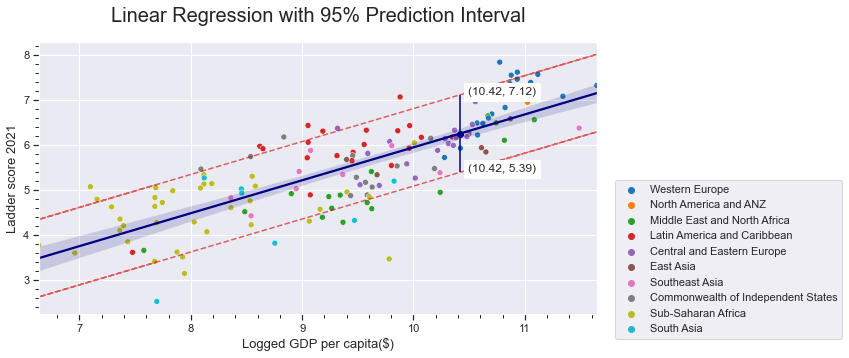

In [16]:
PI(10.42)

## Limitation and References
As value of ladder score that are overly close to either end of the spectrum(0-10) is off of our interest, we decided to limit the logged_gdp_per_capita to be between 6.6 and 11.8.
<br><br>
References for formulas and theories used:<br>
Vrbik, I. (2019). Stat230 Introductory Statistics L08_1SLR. UBC Okanagan.<br>
Vrbik, I. (2019). Stat230 Introductory Statistics L08_2PredConfInt. UBC Okanagan.<br>
Vrbik, I. (2019). Stat230 Introductory Statistics L09_1Diagnostics. UBC Okanagan.<br>